In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [4]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree

In [33]:
def convert_to_cylindrical(coordinate,velocity,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0]):
    #convert a 3 element matrix into a matrix of spherical coordinates
    #I could calculate V_tan and then project it into the new xy plane

    #it also could just be cylindrical and just use V_theta
    #just do cylindrical

    #the basic formula for converting velocities from cartesian to cylindrical is
    #
    # v = (x*dx/dt+y*dy/dt)/r rhat + (x*dy/dt-y*dx/dt)/r thetahat + dz/dt zhat

    import numpy as np

    halo_center = np.asarray(halo_center)
    halo_vel = np.asarray(halo_vel)

    X = np.asarray(coordinate[:,0])-halo_center[0]
    Y = np.asarray(coordinate[:,1])-halo_center[1]
    Z = np.asarray(coordinate[:,2])-halo_center[2]

    VX = np.asarray(velocity[:,0])-halo_vel[0]
    VY = np.asarray(velocity[:,1])-halo_vel[1]
    VZ = np.asarray(velocity[:,2])-halo_vel[2]

    R = np.sqrt(X**2.0+Y**2.0)
    theta = np.arctan2(Y,X)

    D_cylindrical = np.zeros((len(R),3))
    D_cylindrical[:,0] = R
    D_cylindrical[:,1] = theta
    D_cylindrical[:,2] = Z

    Vr = (X*VX+Y*VY)/R
    Vtheta = (X*VY-Y*VX)/R
    Vz = VZ

    V_cylindrical = np.zeros((len(Vr),3))
    V_cylindrical[:,0] = Vr
    V_cylindrical[:,1] = Vtheta
    V_cylindrical[:,2] = Vz

    return D_cylindrical, V_cylindrical

def Calc_average_L_shift(coordinates,masses,velocities):
    #For already shifted and cut cordinates
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance

    coord_mod = coordinates
    mass_mod = masses
    vel_mod = velocities

    coord_shift = coord_mod
    vel_shift = vel_mod

    rcrossv = np.cross(coord_shift,vel_shift)
    L_vec = [mass_mod[ii]*rcrossv[ii] for ii in range(len(rcrossv))]

    L_avg = np.mean(L_vec,axis=0)
    den = np.sqrt(L_avg[0]**2.0+L_avg[1]**2.0+L_avg[2]**2.0)
    return L_avg/den

def Rotate_to_z_axis(coordinates,velocities,rotation_axis):
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance
    #Okay I want to take in a "z" axis, and then rotate the
    #coordinates so that that is the z axis
    #then calculate velocity vectors in that frame and
    #then decompose it into spherical coordinates IN THAT FRAME

    L = np.sqrt(rotation_axis[0]**2.0+rotation_axis[1]**2.0+rotation_axis[2]**2.0) #total length
    R = np.sqrt(rotation_axis[0]**2.0+rotation_axis[1]**2.0) #length in xy plane
    
    ####OLD ROTATION MATRICIES#####
    R1 = np.asarray([[rotation_axis[0]/R,rotation_axis[1]/R,0.0],[-rotation_axis[1]/R,rotation_axis[0]/R,0.0],[0.0,0.0,1.0]]) #rotation about z axis to project into xz plane
    R2 = np.asarray([[rotation_axis[2]/L,0.0,-R/L],[0.0,1.0,0.0],[R/L,0.0,rotation_axis[2]/L]]) #rotation about y axis to make given axis the z axis
    
    #apply rotation to coordinates and velocities
    
    coord_rotate = np.asarray([R2.dot(R1.dot(xx)) for xx in coordinates])
    vel_rotate = np.asarray([R2.dot(R1.dot(xx)) for xx in velocities])

    return coord_rotate, vel_rotate

def principle_axes(coordinates,masses,rad,center=None):
    #This code calculates principle axes of a given star particle
    #This is basically a modified version of Andrew Wetzel's code
    #to do the same thing
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance

    if center == None:
        dm_dist_val = np.linalg.norm(coordinates,axis=1)
    else:    
        dm_dist_val = get_distance(coordinates, center)

    dist_mask = (dm_dist_val<=rad)
    coord_mod = coordinates[dist_mask]
    mass_mod = masses[dist_mask]
    
    if center == None:
        dm_dist = coord_mod
    else:
        dm_dist = get_distance_vector(coord_mod, center)
    
    weights = mass_mod/np.median(mass_mod)

    xx = np.sum(weights * dm_dist[:,0]**2.0)
    yy = np.sum(weights * dm_dist[:,1]**2.0)
    zz = np.sum(weights * dm_dist[:,2]**2.0)
    
    xy = yx = np.sum(weights * dm_dist[:,0] * dm_dist[:,1])
    xz = zx = np.sum(weights * dm_dist[:,0] * dm_dist[:,2])
    yz = zy = np.sum(weights * dm_dist[:,1] * dm_dist[:,2])
    
    I_tensor = [[xx, xy, xz],[yx, yy, yz],[zx, zy, zz]]

    eigen_values, eigen_vectors = np.linalg.eig(I_tensor)

    # order eigen-vectors by eigen-values, from largest to smallest                                  
    eigen_indices_sorted = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[eigen_indices_sorted]
    eigen_values /= eigen_values.max()  # renormalize to 1                                           
    # make eigen_vectors[0] corresponds to vector of eigen_values[0]                                 
    eigen_vectors = eigen_vectors.transpose()[eigen_indices_sorted]

    axis_ratios = np.sqrt(
        [eigen_values[2] / eigen_values[0],
         eigen_values[2] / eigen_values[1],
         eigen_values[1] / eigen_values[0]]
    )

    return eigen_values, eigen_vectors, axis_ratios

In [6]:
#The correlation program is busted for reason that I don't quite understand
#as far as I can tell it has to be one of 3 things
#
# 1) a problem with the input particles either stars or dm
# 2) a problem with the NN algorithms
# 3) a problem with the sorting algorithms
#
# 1 is easy to check I just need to load up the particle data and plot it to see if it
# looks okay:

#Now it turns out my sample is very biased
#about 1% of the dm particles have associated stellar mass
#
#Apparently you can pass a bias to the network and it will
#work with that
#
#First load the data

f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

pos_halo_train = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo_train = f_halo['velocity'][:]

h = 0.702

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos_train = pos_halo_train[host_id]
host_vel_train = vel_halo_train[host_id]

f_parts = h5py.File('../m12i_res_7100_cdm/output/snapshot_600.hdf5')

f_stars = f_parts['PartType4']

star_coords = f_stars['Coordinates'][:]/h
star_vel = f_stars['Velocities'][:]
star_mass = f_stars['Masses'][:]*1.0e10/h


In [12]:
coord_diff = star_coords-host_pos_train
vel_diff = star_vel-host_vel_train

L_vec =  Calc_average_L_shift(coord_diff,star_mass,vel_diff)

print L_vec

[ 0.85041899 -0.08385842 -0.51937973]


In [14]:
#I'm just going to output the moment of inertia tensor

e_val, e_vec, axis_ratios = principle_axes(coord_diff,star_mass,20.0)

print e_val
print e_vec


[1.         0.98534915 0.19305518]
[[ 0.21920072 -0.97432798 -0.05134233]
 [-0.94393702 -0.22508887  0.24149101]
 [-0.24684803 -0.00447108 -0.96904389]]


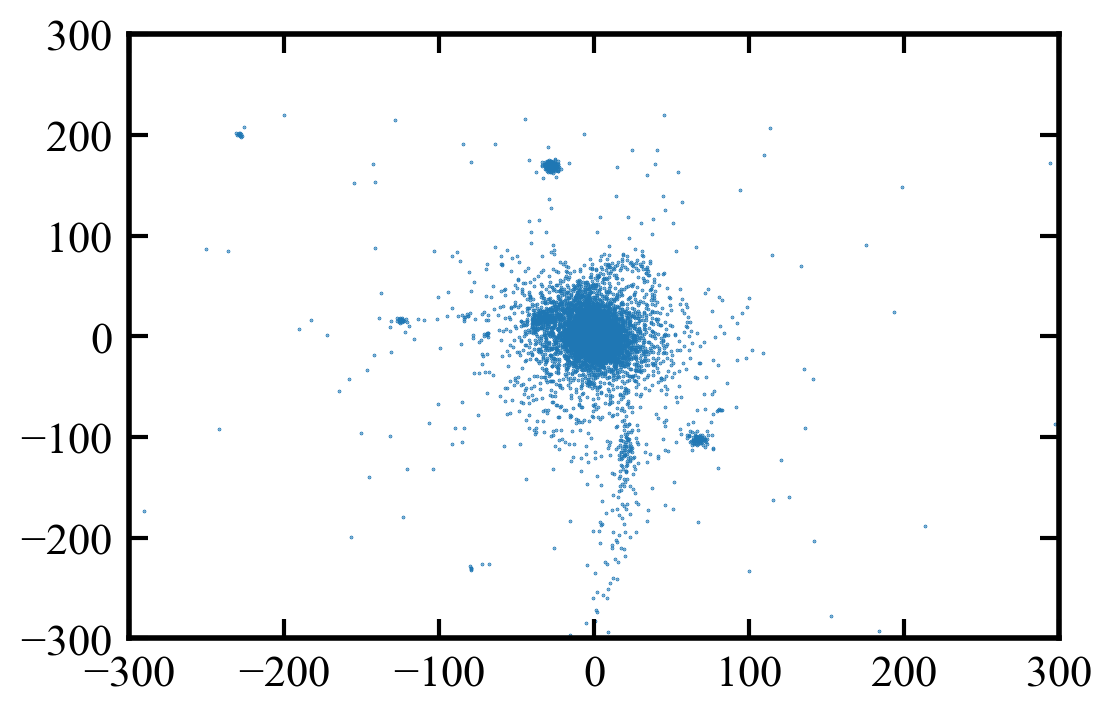

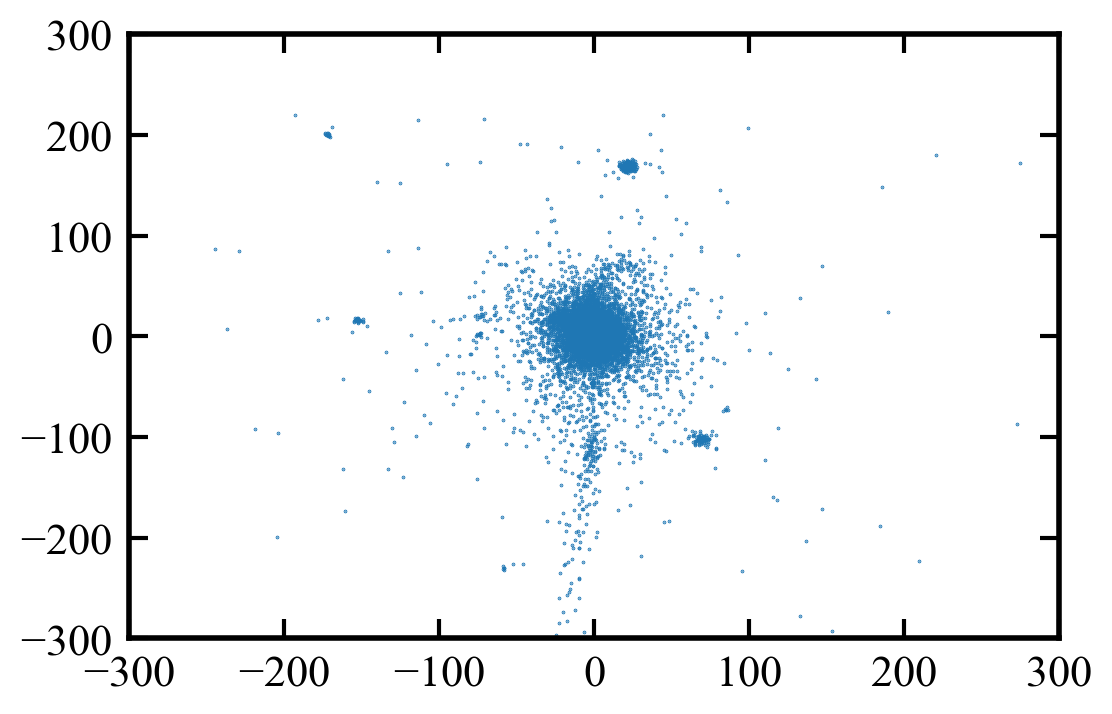

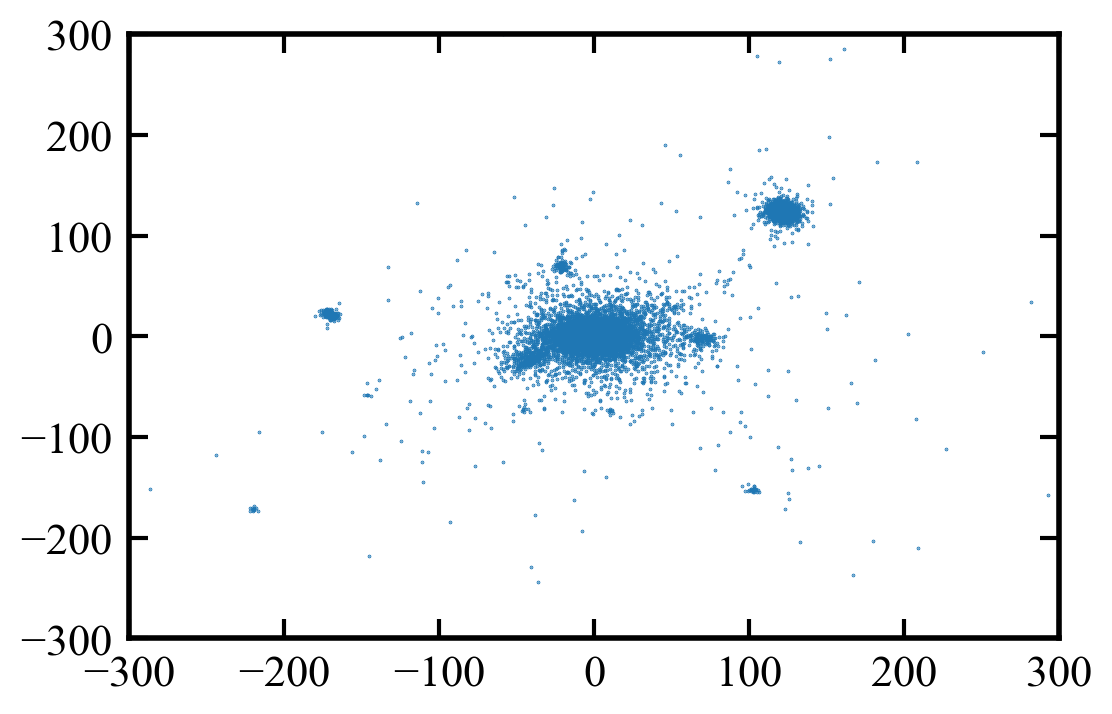

In [55]:
#I think e_vec[0] should be the correct axis
part_rotate, vel_rotate = Rotate_to_z_axis(coord_diff, vel_diff, e_vec[2])

plt.scatter(rotate_coords[:,0][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(part_rotate[:,2][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(part_rotate[:,0][::100],part_rotate[:,2][::100],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

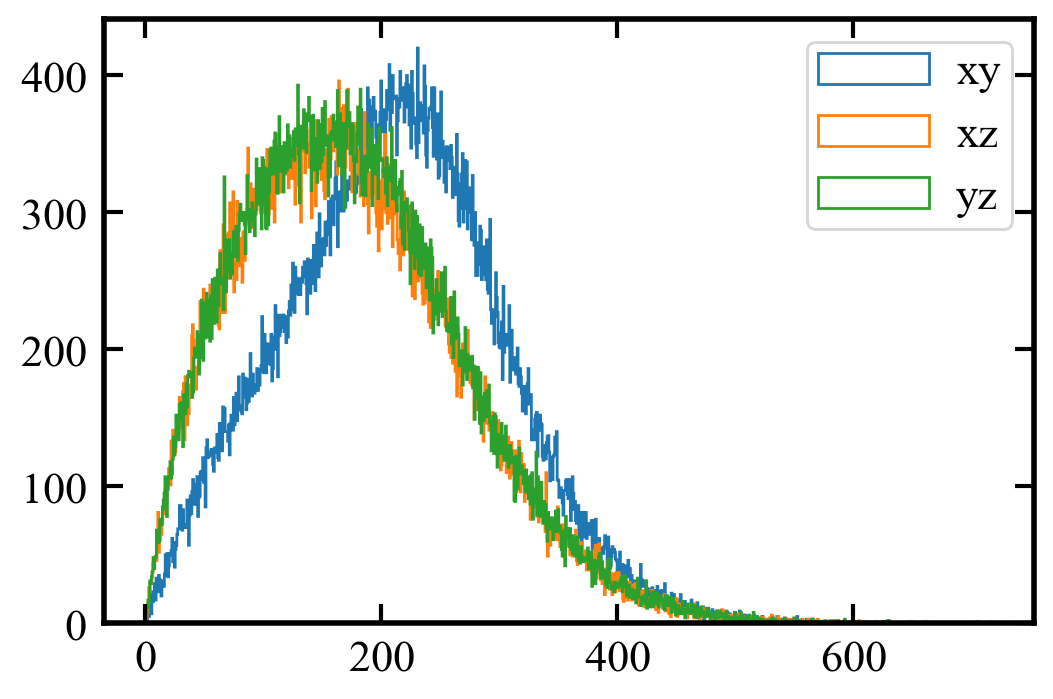

In [41]:
#lets just calculate vxy, vxz, vzy and see what they look like

dist = np.linalg.norm(coord_diff,axis=1)
dist_mask = (dist<20.0)

Vxy = np.sqrt(vel_rotate[:,0][dist_mask]**2.0+vel_rotate[:,1][dist_mask]**2.0)

Vxz = np.sqrt(vel_rotate[:,0][dist_mask]**2.0+vel_rotate[:,2][dist_mask]**2.0)

Vzy = np.sqrt(vel_rotate[:,1][dist_mask]**2.0+vel_rotate[:,2][dist_mask]**2.0)

plt.hist(Vxy[::100],bins=1000,histtype='step',color='C0',label='xy')
plt.hist(Vxz[::100],bins=1000,histtype='step',color='C1',label='xz')
plt.hist(Vzy[::100],bins=1000,histtype='step',color='C2',label='yz')
plt.legend()
plt.show()

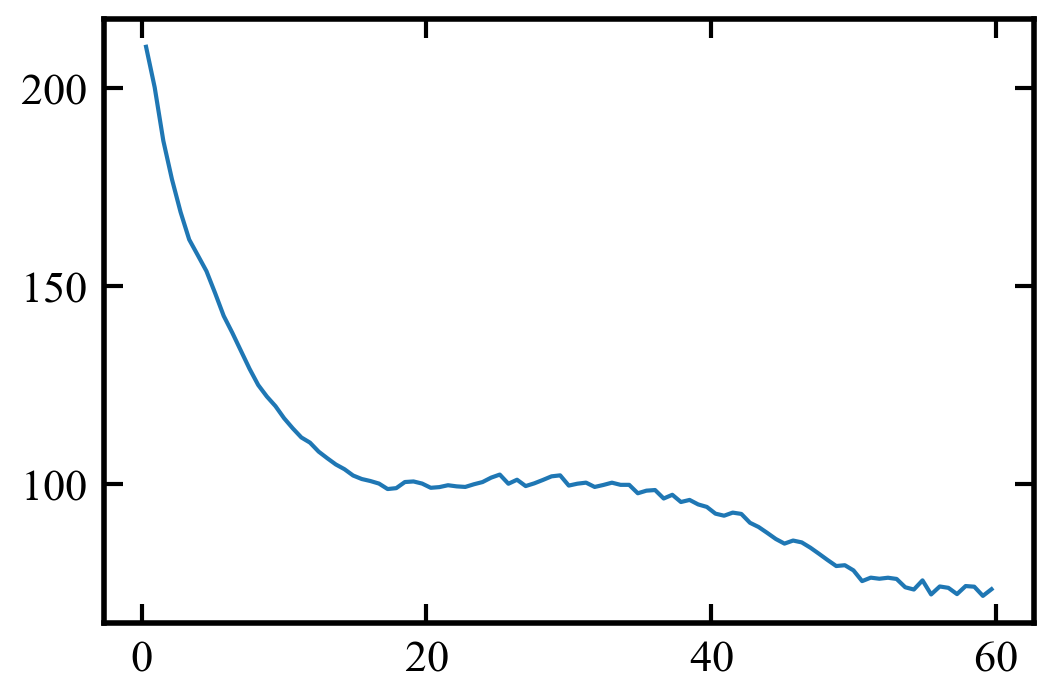

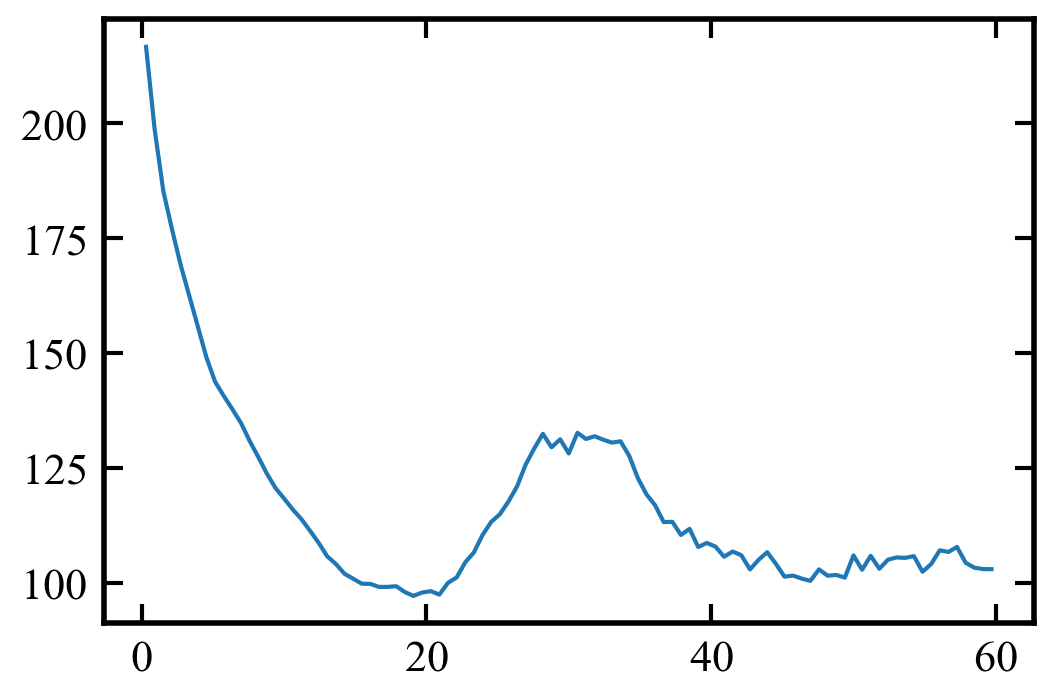

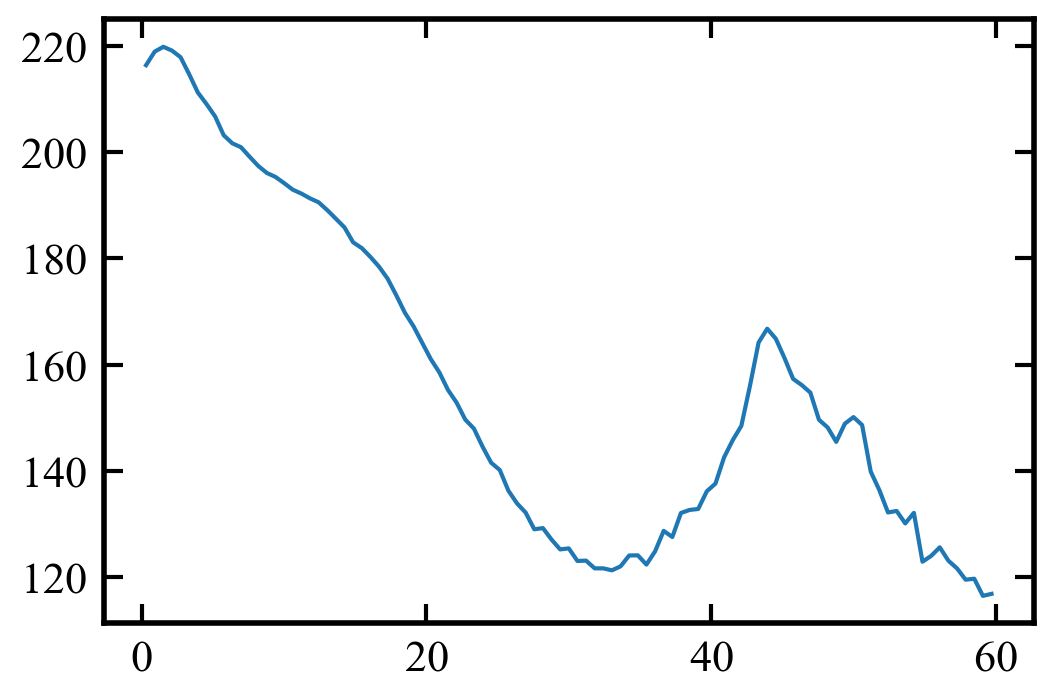

In [43]:
#Lets make a rotation curve in the x-z plane

R_xz = np.sqrt(part_rotate[:,0]**2.0+part_rotate[:,2]**2.0)

radius_bins = np.linspace(0.0,60.0,100)

R_list, V_rot_list = [],[]
for ii in range(len(radius_bins)-1):
    R_mask = (R_xz>radius_bins[ii])&(R_xz<radius_bins[ii+1])
    V_xz = np.sqrt(vel_rotate[:,0][R_mask]**2.0
                   +vel_rotate[:,2][R_mask]**2.0)
    
    V_rot = np.mean(V_xz)
    
    V_rot_list.append(V_rot)
    R_list.append((radius_bins[ii]+radius_bins[ii+1])/2.0)
    
plt.plot(R_list,V_rot_list)
plt.show()

#yz 

R_yz = np.sqrt(part_rotate[:,1]**2.0+part_rotate[:,2]**2.0)

R_list, V_rot_list = [],[]
for ii in range(len(radius_bins)-1):
    R_mask = (R_yz>radius_bins[ii])&(R_yz<radius_bins[ii+1])
    V_yz = np.sqrt(vel_rotate[:,1][R_mask]**2.0
                   +vel_rotate[:,2][R_mask]**2.0)
    
    V_rot = np.mean(V_yz)
    
    V_rot_list.append(V_rot)
    R_list.append((radius_bins[ii]+radius_bins[ii+1])/2.0)
    
plt.plot(R_list,V_rot_list)
plt.show()

#yz 

R_xy = np.sqrt(part_rotate[:,0]**2.0+part_rotate[:,1]**2.0)

R_list, V_rot_list = [],[]
for ii in range(len(radius_bins)-1):
    R_mask = (R_xy>radius_bins[ii])&(R_xy<radius_bins[ii+1])
    V_xy = np.sqrt(vel_rotate[:,0][R_mask]**2.0
                   +vel_rotate[:,1][R_mask]**2.0)
    
    V_rot = np.mean(V_xy)
    
    V_rot_list.append(V_rot)
    R_list.append((radius_bins[ii]+radius_bins[ii+1])/2.0)
    
plt.plot(R_list,V_rot_list)
plt.show()

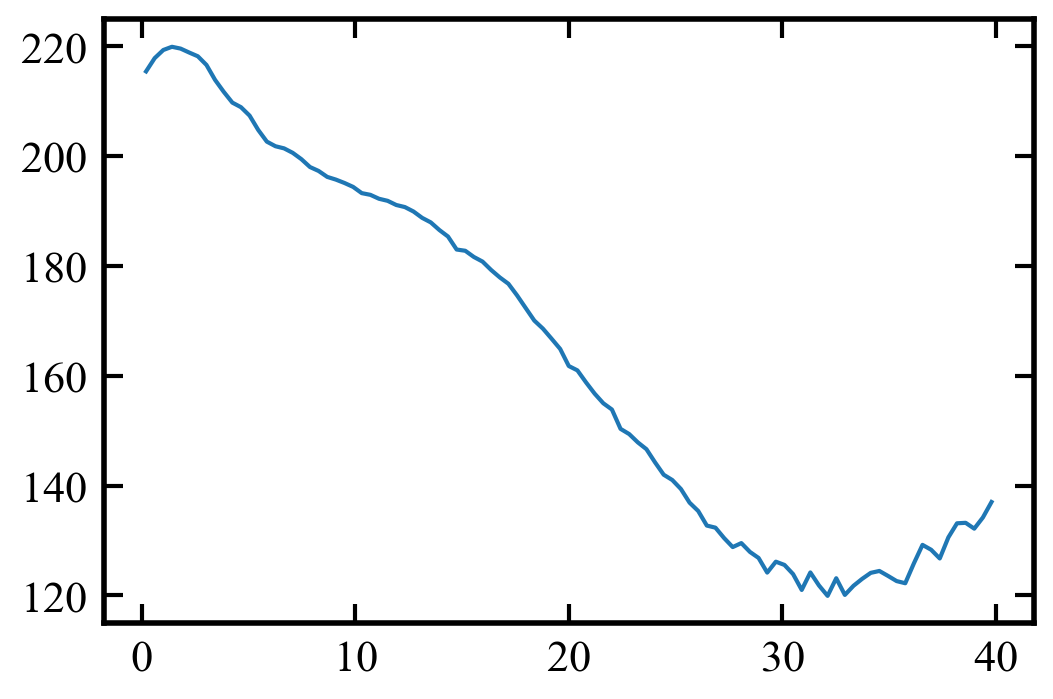

In [57]:
R_xy = np.sqrt(part_rotate[:,0]**2.0+part_rotate[:,1]**2.0)

radius_bins = np.linspace(0.0,40.0,100)

R_list, V_rot_list = [],[]
for ii in range(len(radius_bins)-1):
    R_mask = (R_xy>radius_bins[ii])&(R_xy<radius_bins[ii+1])
    V_xy = np.sqrt(vel_rotate[:,0][R_mask]**2.0
                   +vel_rotate[:,1][R_mask]**2.0)
    
    V_rot = np.mean(V_xy)
    
    V_rot_list.append(V_rot)
    R_list.append((radius_bins[ii]+radius_bins[ii+1])/2.0)
    
plt.plot(R_list,V_rot_list)
plt.show()

In [9]:
dist = np.linalg.norm(coord_diff,axis=1)

gal_mask = (dist<20.0)

L_vec =  Calc_average_L_shift(coord_diff[gal_mask],star_mass[gal_mask],vel_diff[gal_mask])

print L_vec

[-0.25230393 -0.00831013 -0.96761235]


In [ ]:
from random import random

#okay the rotation seems to work fine
#So it must be the angular momentum calculation
#lets go ahead and choose some random vectors, rotate to them and calculate Lz
#Vtheta = (X*VY-Y*VX)/R

coord_gal = star_coords[gal_mask]-host_pos_train
vel_gal = star_vel[gal_mask]-host_vel_train
mass_gal = star_mass[gal_mask]

kpc_to_km = 1.0/3.086e16

Lz_list = []
Vt_list = []

Lz_max = 0.0

for ii in range(10):
    print ii
    test_vec = np.array([random(),random(),random()])
    test_vec_norm = test_vec/np.linalg.norm(test_vec)
    
    rotate_coords, rotate_vels = Rotate_to_z_axis(coord_gal, vel_gal, test_vec_norm)
    
    Lz = mass_gal*(rotate_coords[:,0]*rotate_vels[:,1] - 
                   rotate_coords[:,1]*rotate_vels[:,0])*kpc_to_km
    Vt = Lz/(mass_gal*np.sqrt((rotate_coords[:,0]*kpc_to_km)**2.0+(rotate_coords[:,1]*kpc_to_km)**2.0))
    R = np.sqrt(rotate_coords[:,0]**2.0+rotate_coords[:,1]**2.0)
    Vtheta = (rotate_coords[:,0]*rotate_vels[:,1]-rotate_coords[:,1]*rotate_vels[:,0])/R
    
    Lz_avg = np.mean(Lz)
    Vt_avg = np.mean(Vt)
    
    #print Lz_avg, Vt_avg, np.mean(Vtheta)

    if abs(Lz_avg) > abs(Lz_max):
        Lz_max = Lz_avg
        vec_max = test_vec_norm
        Vt_max = Vt_avg 
        
    Lz_list.append(Lz_avg)
    Vt_list.append(Vt_avg)

print Lz_max
print vec_max
print Vt_max

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
print Lz_max
print vec_max
print Vt_max

In [17]:
part_rotate, vel_rotate =  Rotate_to_z_axis(coord_diff,vel_diff,vec_max)

#coord_cyl_disk, vel_cyl_disk = convert_to_cylindrical(part_rotate,vel_rotate)

#print part_rotate.shape
#print coord_diff.shape

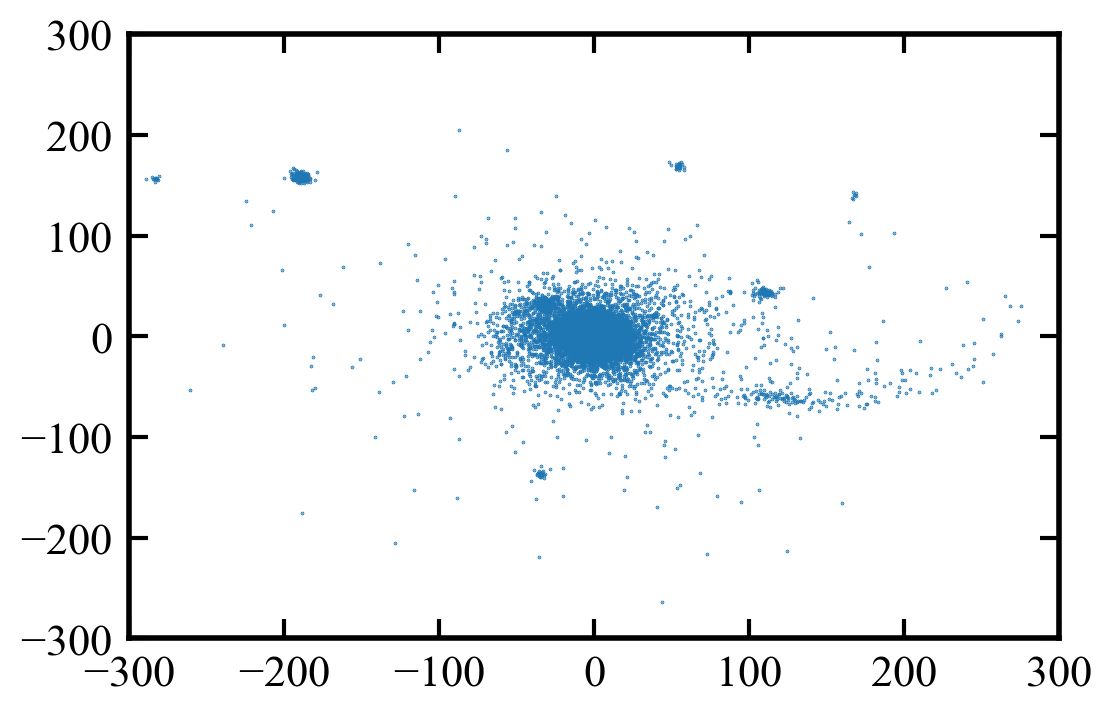

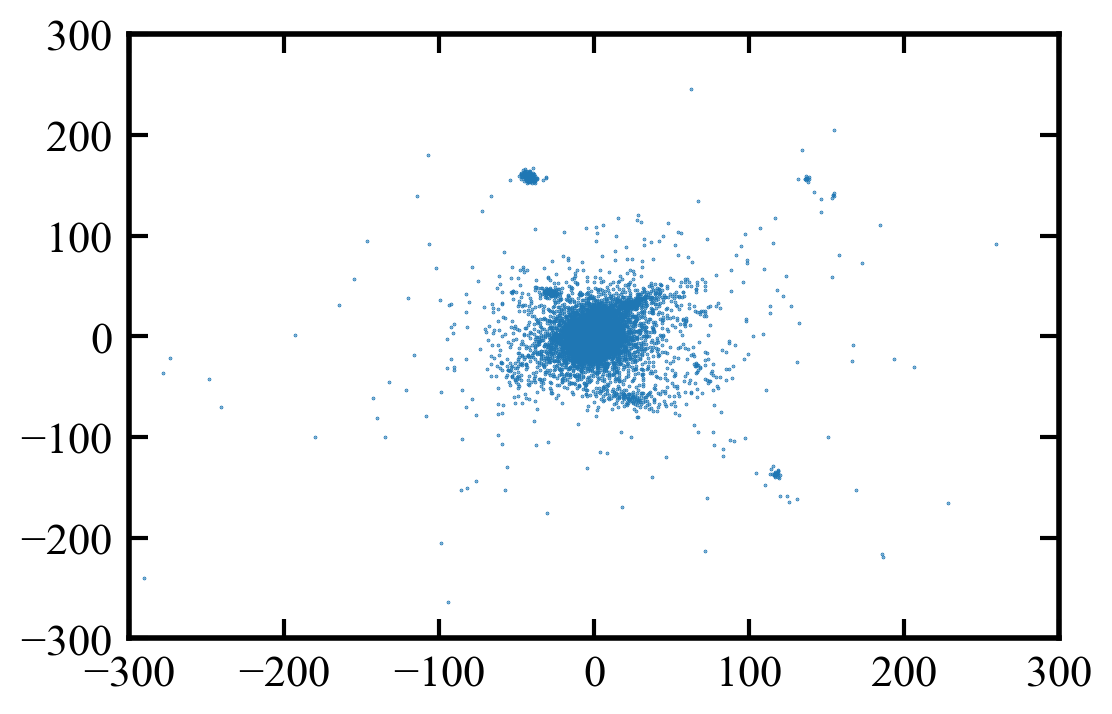

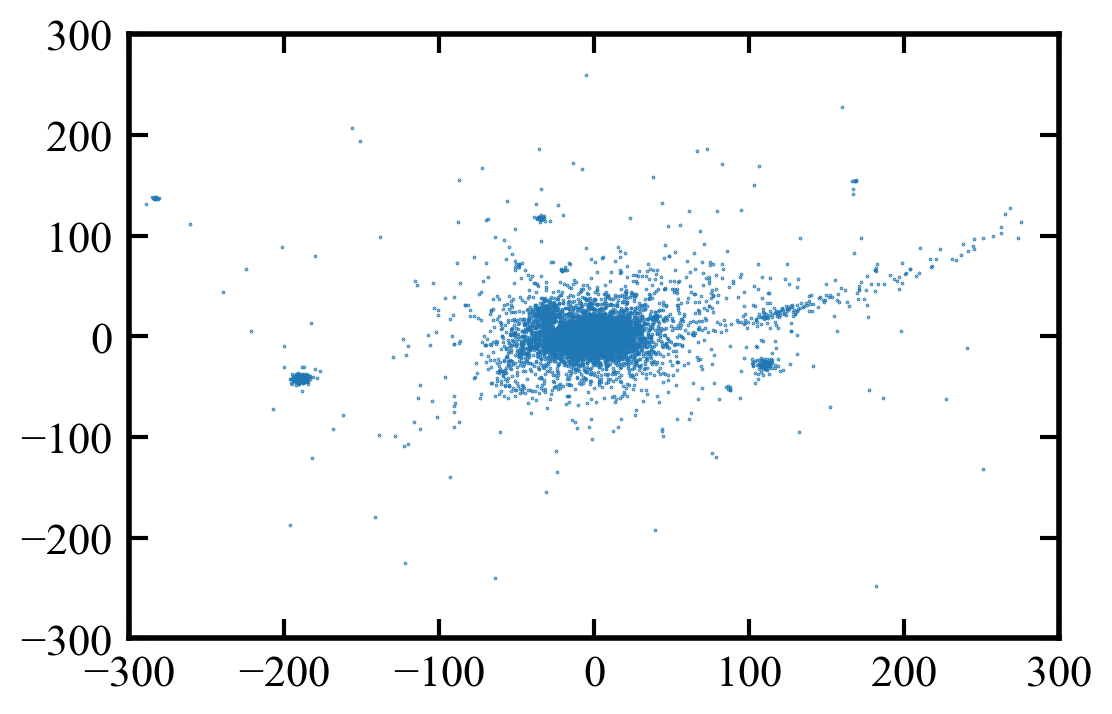

In [18]:
plt.scatter(part_rotate[:,0][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(part_rotate[:,2][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(part_rotate[:,0][::100],part_rotate[:,2][::100],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

[-0.25230393 -0.00831013 -0.96761235]


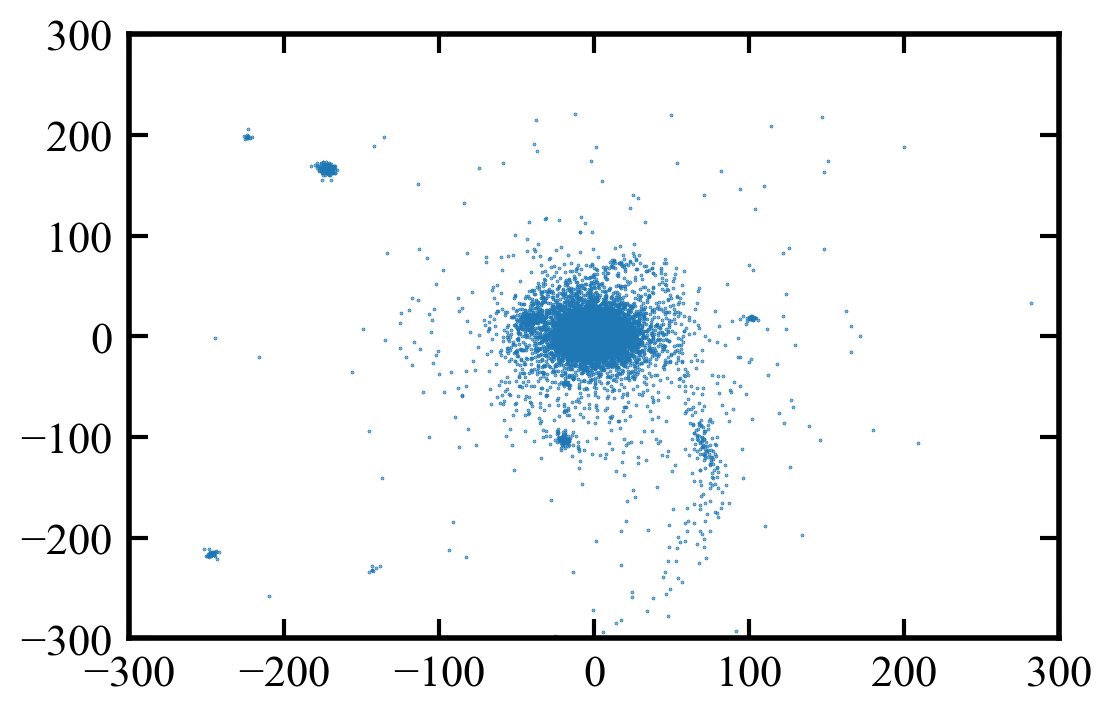

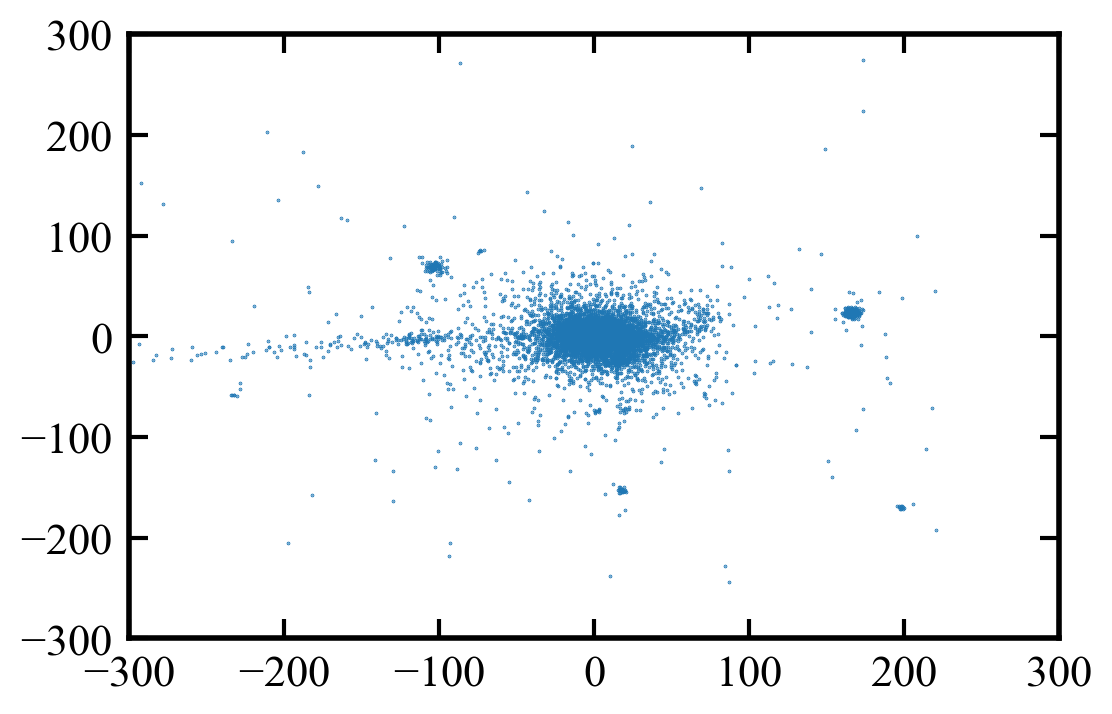

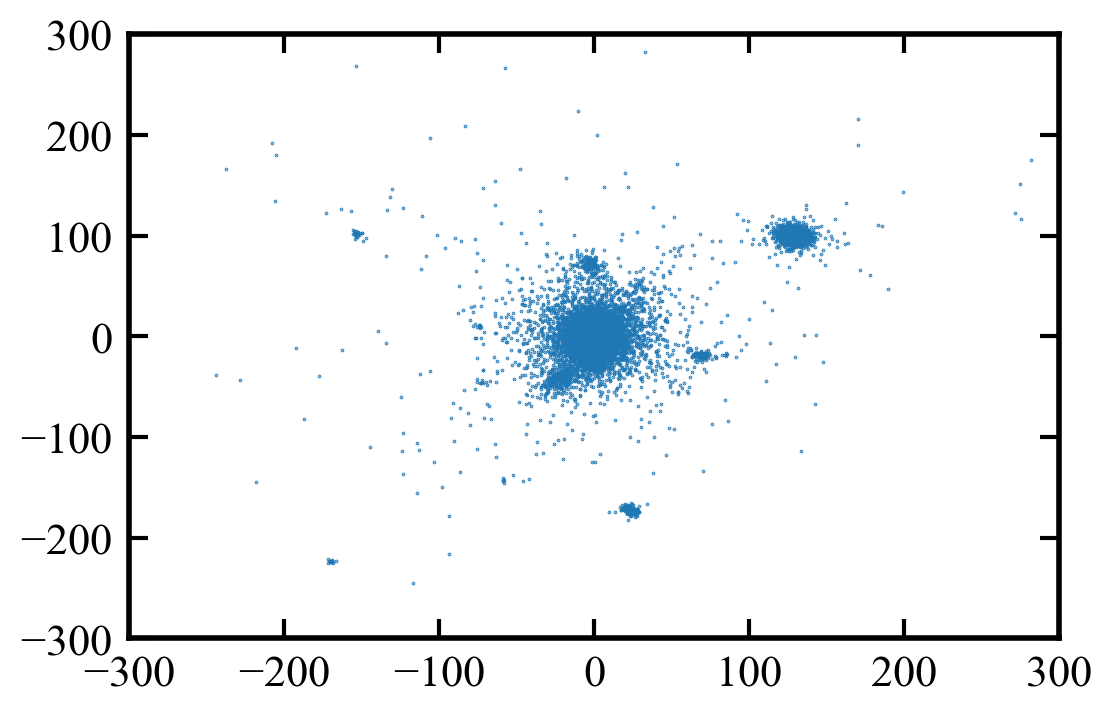

In [58]:
#Hmmmmm this seems to not be working correctly. the coordinates are rotated, but they don't
#seem to be focused on the disk, potential issues
#
# 1) the random satellite galaxies greatly throw off the calculation
#        - remove all stars outside of 20 kpc?
# 2) the calculation has a flaw in it somewhere (potentially the calculation of L)
#        - calculate L for random vectors along unit sphere and compare
#
#Lets try to remove stuff outside of 20kpc and redo the transform

coord_diff = star_coords-host_pos_train
vel_diff = star_vel-host_vel_train

#I can actually just do it when I'm calculating L_vec and then go back to the normal
#coordiantes for the transform

dist = np.linalg.norm(coord_diff,axis=1)
galaxy_mask = (dist<20.0)

L_vec =  Calc_average_L_shift(coord_diff[galaxy_mask],star_mass[galaxy_mask],vel_diff[galaxy_mask])

part_rotate, vel_rotate =  Rotate_to_z_axis(coord_diff,vel_diff,L_vec)

coord_cyl_disk, vel_cyl_disk = convert_to_cylindrical(part_rotate,vel_rotate)

print L_vec

plt.scatter(part_rotate[:,0][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,1][::100],part_rotate[:,2][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,2][::100],part_rotate[:,0][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()


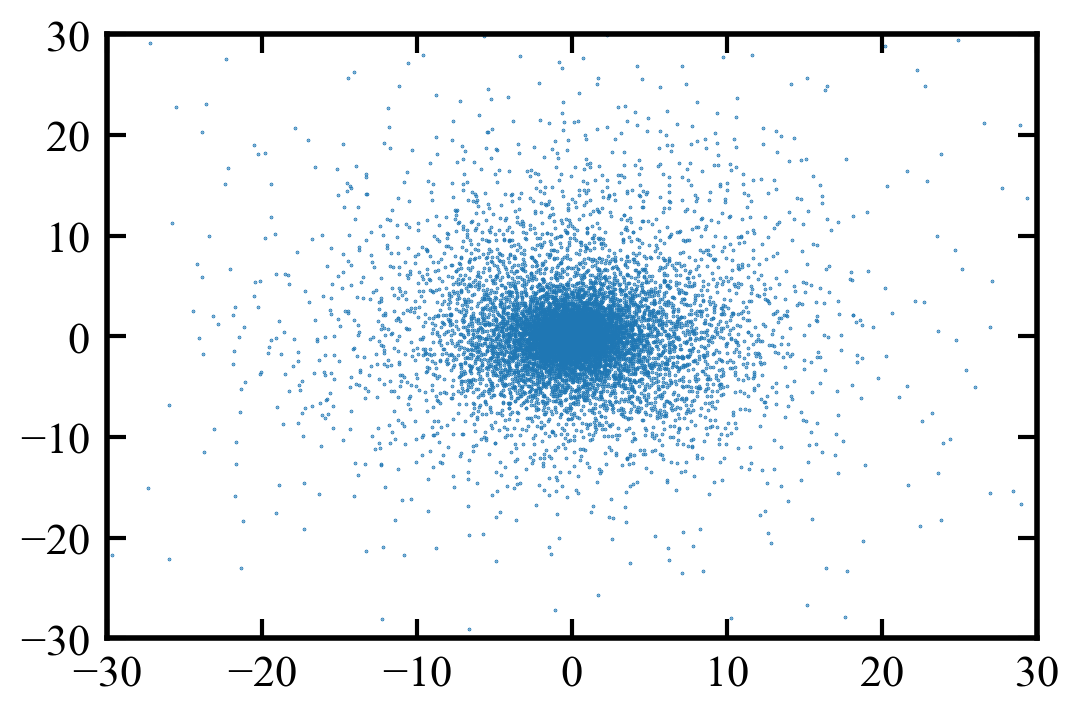

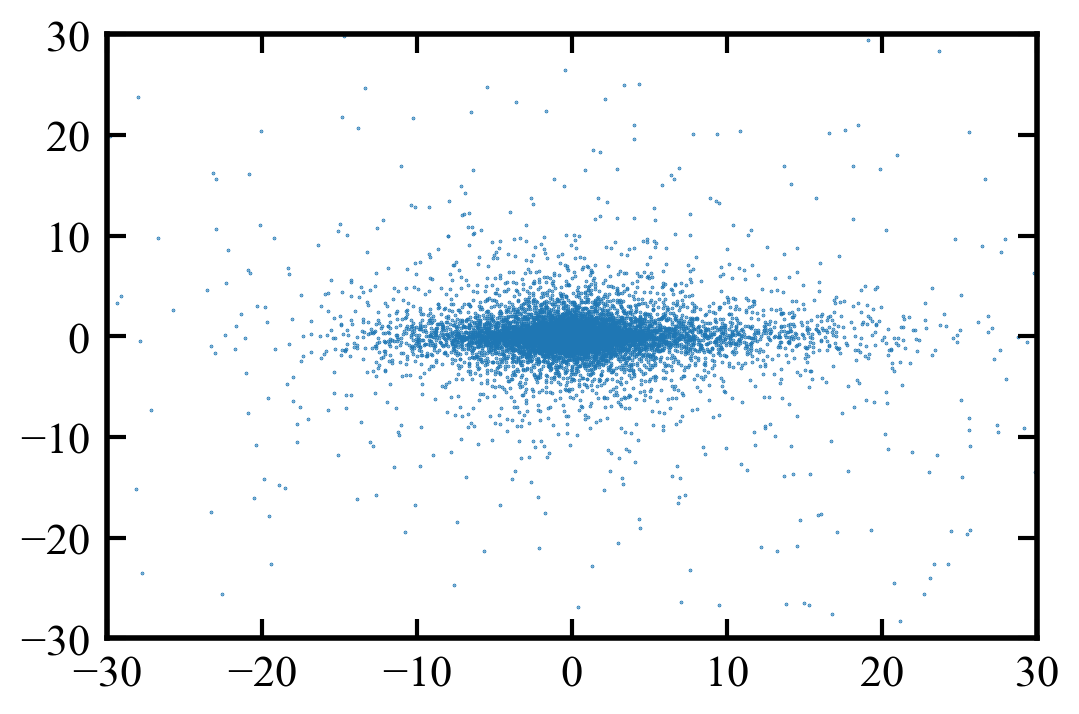

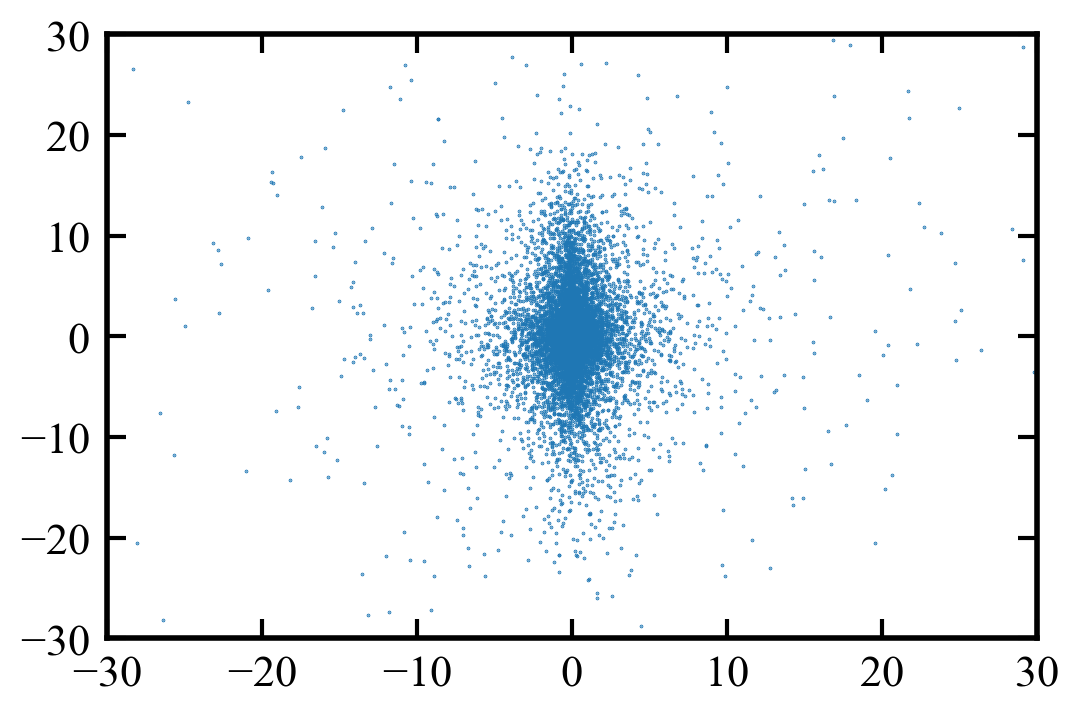

In [61]:
plt.scatter(part_rotate[:,0][::1000],part_rotate[:,1][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,1][::1000],part_rotate[:,2][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,2][::1000],part_rotate[:,0][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

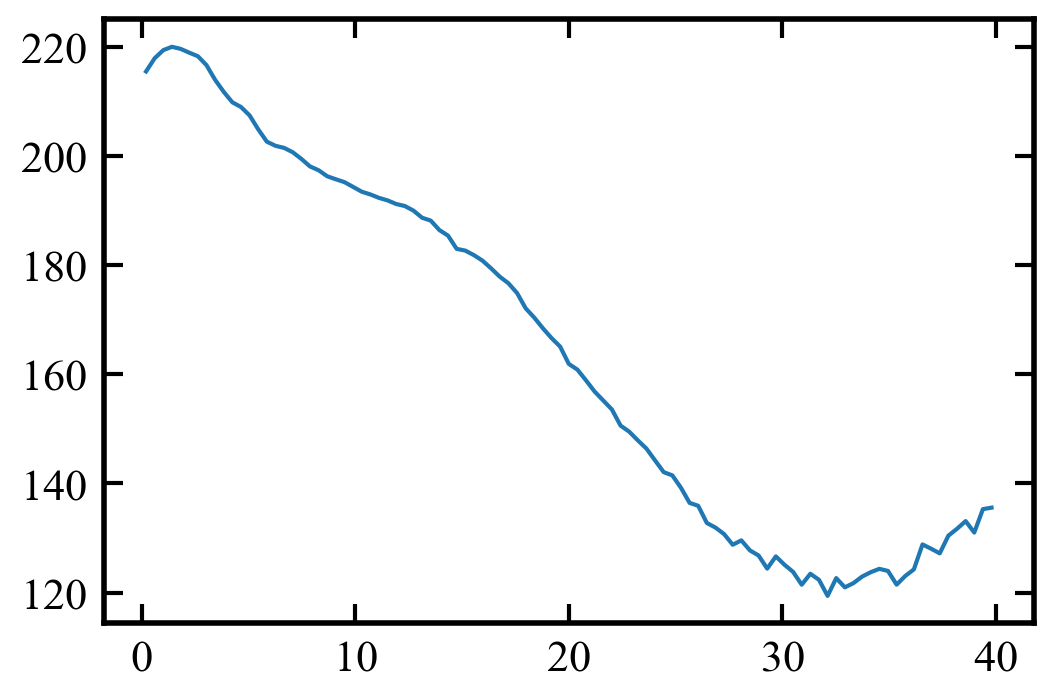

In [68]:
R_xy = coord_cyl_disk[:,0]
v_phi = np.sqrt(vel_rotate[:,0]**2.0+vel_rotate[:,1]**2.0)

r_bins = np.linspace(0.0,40.0,100)

R_list,v_list = [],[]

for ii in range(len(r_bins)-1):
    bin_mask = (R_xy>=r_bins[ii])&(R_xy<r_bins[ii+1])
    R_list.append((r_bins[ii]+r_bins[ii+1])/2.0)
    v_list.append(np.mean(v_phi[bin_mask]))
    
plt.plot(R_list,v_list)
plt.show()


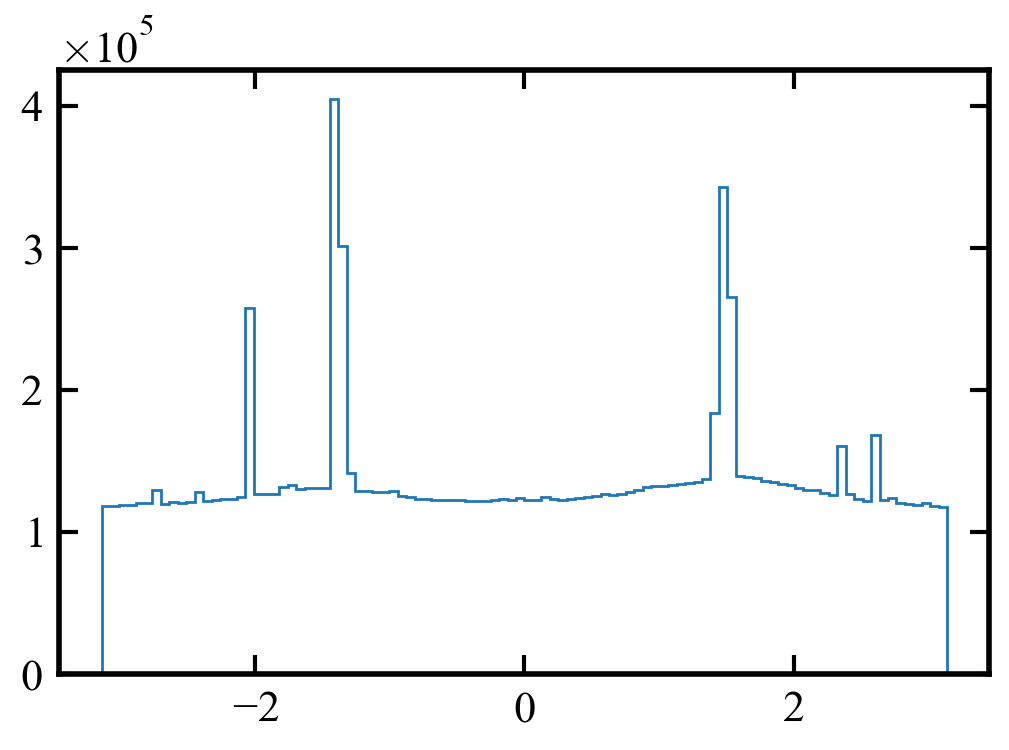

In [63]:
plt.hist(v_phi,bins=100,histtype='step')
plt.show()

In [71]:
V_t_cart = np.linalg.norm(vel_rotate,axis=1)
V_t_cyl = np.linalg.norm(vel_cyl_disk,axis=1)

print V_t_cart
print V_t_cyl

np.testing.assert_array_almost_equal(V_t_cart,V_t_cyl)

[197.58059301 259.96220156 183.24871783 ... 134.05836518  62.947814
 122.36510142]
[197.58059301 259.96220156 183.24871783 ... 134.05836518  62.947814
 122.36510142]
